In [115]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# 한글 + 전각문자 지원 폰트로 변경 (예: AppleGothic, NanumGothic 등)
plt.rcParams['font.family'] = 'AppleGothic'  # macOS의 경우
# plt.rcParams['font.family'] = 'NanumGothic'  # Windows/Linux

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

In [116]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pyedflib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb

In [39]:
# 경로 설정
base_path = "sleep-edf-database-expanded-1.0.0/"
sc_path = os.path.join(base_path, "sleep-cassette/")
st_path = os.path.join(base_path, "sleep-telemetry/")
more_data_dir = "more_data"


In [40]:
def get_st_paths(subject_ids, folder_path):
    file_tuples = []
    all_files = os.listdir(folder_path)
    hyp_files = [f for f in all_files if f.endswith("-Hypnogram.edf")]

    for sid in subject_ids:
        psg_fname = f"{sid}-PSG.edf"
        psg_path = os.path.join(folder_path, psg_fname)

        if not os.path.exists(psg_path):
            continue

        prefix = sid[:6]
        matched = [h for h in hyp_files if prefix in h]
        if len(matched) == 1:
            hyp_path = os.path.join(folder_path, matched[0])
            file_tuples.append((sid, psg_path, hyp_path, "ST"))
        elif len(matched) > 1:
            print(f"❗ ST Hypnogram 여러 개 매칭됨 ({sid}): {matched}")
        else:
            print(f"❗ ST Hypnogram 없음 (prefix={prefix})")

    return file_tuples


def get_sc_paths(subject_ids, folder_path):
    file_tuples = []
    all_files = os.listdir(folder_path)
    hyp_files = [f for f in all_files if f.endswith("-Hypnogram.edf")]

    for sid in subject_ids:
        psg_fname = f"{sid}-PSG.edf"
        psg_path = os.path.join(folder_path, psg_fname)

        if not os.path.exists(psg_path):
            # print(f"❗ SC PSG 파일 없음: {psg_path}")
            continue

        # Sleep-EDF에서는 Hypnogram 파일의 이름이 PSG보다 짧은 prefix로 시작함 (예: SC4001E)
        prefix = sid[:-1]  # 마지막 문자(보통 0)를 제거한 접두어
        matched = [h for h in hyp_files if h.startswith(prefix)]

        if len(matched) == 1:
            hyp_path = os.path.join(folder_path, matched[0])
            file_tuples.append((sid, psg_path, hyp_path, "SC"))
        elif len(matched) > 1:
            print(f"❗ SC Hypnogram 여러 개 매칭됨 ({sid}): {matched}")
            continue
        else:
            print(f"❗ SC Hypnogram 없음 (prefix={prefix})")
            continue

    return file_tuples

In [41]:
# 수면 단계 정의
sleep_stages_edf = ['N1', 'N2', 'N3', 'R']
sleep_stages_xlsx = ['S1', 'S2', 'S3', 'REM']

# XLSX → EDF 수면 단계 이름 매핑
xlsx_to_edf_stage_map = {
    'S1': 'N1',
    'S2': 'N2',
    'S3': 'N3',
    'REM': 'R',
    'WAKE': 'W',
    'MT': 'Movement',
    'UNDEF': 'Undefined'
}


In [42]:
import os
import numpy as np
import pandas as pd
import pyedflib

# global sleep stages
sleep_stages_edf = ['N1', 'N2', 'N3', 'R']
xlsx_to_edf_stage_map = {
    'S1': 'N1',
    'S2': 'N2',
    'S3': 'N3',
    'REM': 'R',
    'WAKE': 'W',
    'MT': 'Movement',
    'UNDEF': 'Undefined'
}

def trim_long_wake_edges(epoch_stages, wake_label='W', min_trim_minutes=10, epoch_duration=30.0):
    """Trim leading/trailing long wake periods from the full recording."""
    min_trim_epochs = int((min_trim_minutes * 60) / epoch_duration)
    # trim front
    start = 0
    for s in epoch_stages:
        if s != wake_label:
            break
        start += 1
    if start < min_trim_epochs:
        start = 0
    # trim back
    end = len(epoch_stages)
    for s in reversed(epoch_stages):
        if s != wake_label:
            break
        end -= 1
    if len(epoch_stages) - end < min_trim_epochs:
        end = len(epoch_stages)
    return epoch_stages[start:end]

def trim_inner_long_wake(seq, wake_label='W', threshold_epochs=40):
    """Trim inner segments of consecutive wake longer than threshold."""
    # front
    i = 0
    while i < len(seq) and seq[i] == wake_label:
        i += 1
    if i >= threshold_epochs:
        seq = seq[i:]
    # back
    j = len(seq) - 1
    while j >= 0 and seq[j] == wake_label:
        j -= 1
    if (len(seq) - 1 - j) >= threshold_epochs:
        seq = seq[:j+1]
    return seq

def extract_features_from_epoch_series(epoch_stages, sleep_stage_set):
    """Compute features (TIB, TST, SE, stage durations, awakenings, shifts)."""
    features = {}
    epoch_duration = 30.0
    n = len(epoch_stages)
    tib = n * epoch_duration
    sleep_epochs = [s for s in epoch_stages if s in sleep_stage_set]
    tst = len(sleep_epochs) * epoch_duration

    features['TIB_min']    = tib / 60.0
    features['TST_min']    = tst / 60.0
    features['SE_percent'] = (tst / tib) * 100 if tib>0 else 0.0

    counts = pd.Series(epoch_stages).value_counts()
    for stage, ct in counts.items():
        features[f'{stage}_min'] = ct * epoch_duration / 60.0
        if stage in sleep_stage_set:
            features[f'{stage}_percent_TST'] = (ct / len(sleep_epochs)) * 100 if len(sleep_epochs)>0 else 0.0
        else:
            features[f'{stage}_percent_TIB'] = (ct / n) * 100 if n>0 else 0.0

    # SOL & WASO
    sol = next((i for i,s in enumerate(epoch_stages) if s in sleep_stage_set), None)
    waso = 0.0
    if sol is not None:
        in_wake = False
        for s in epoch_stages[sol:]:
            if s not in sleep_stage_set and not in_wake:
                waso += epoch_duration
                in_wake = True
            elif s in sleep_stage_set:
                in_wake = False
    features['WASO_min'] = waso / 60.0
    features['SOL_min']  = (sol * epoch_duration / 60.0) if sol is not None else features['TIB_min']

    # REML
    reml = None
    if sol is not None:
        for i in range(sol, n):
            if epoch_stages[i] in ['R','REM']:
                reml = i
                break
    features['REML_min'] = ((reml-sol)*epoch_duration/60.0) if (sol is not None and reml is not None) else features['TST_min']

    # awakenings & stage shifts
    wake_count = 0
    if sol is not None:
        in_wake = False
        for s in epoch_stages[sol:]:
            if s not in sleep_stage_set and not in_wake:
                wake_count += 1
                in_wake = True
            elif s in sleep_stage_set:
                in_wake = False
    features['Num_Awakenings']    = wake_count
    features['Num_Stage_Shifts']  = sum(1 for i in range(1,n) if epoch_stages[i]!=epoch_stages[i-1])

    return pd.Series(features)

def extract_hypnogram_features_edf(hyp_path):
    """Extract features from an EDF hypnogram file."""
    try:
        f = pyedflib.EdfReader(hyp_path)
        onsets, durations, annotations = f.readAnnotations()
        f._close()
        if len(onsets)==0:
            return None

        epoch_duration = 30.0
        total_sec = onsets[-1] + durations[-1]
        n_epochs = int(round(total_sec/epoch_duration))
        stages = ['']*n_epochs

        # assign stages
        for onset, dur, ann in zip(onsets,durations,annotations):
            idx = int(round(onset/epoch_duration))
            cnt = int(round(dur/epoch_duration))
            label = ann.replace('Sleep stage ','').strip().replace('?','Undefined').replace(' (Movement)','Movement')
            for i in range(cnt):
                if idx+i < n_epochs:
                    stages[idx+i]=label
        stages = [s if s else 'Undefined' for s in stages]

        # trim edges
        stages = trim_long_wake_edges(stages)
        if not stages:
            return None

        # inner wake trim within sleep interval
        idxs = [i for i,s in enumerate(stages) if s in sleep_stages_edf]
        if not idxs:
            return None
        core = stages[idxs[0]:idxs[-1]+1]
        core = trim_inner_long_wake(core)
        if not core:
            return None

        return extract_features_from_epoch_series(core, sleep_stages_edf)

    except Exception as e:
        print(f"❌ EDF error ({hyp_path}): {e}")
        return None

def extract_hypnogram_features_xlsx(path):
    """Extract features from an XLSX hypnogram file."""
    df = pd.read_excel(path)
    # normalize column names
    df.columns = df.columns.str.strip().str.lower()

    # find stage column
    str_cols   = [c for c in df.columns if isinstance(c,str)]
    stage_cols = [c for c in str_cols if 'stage' in c]
    stage_col  = stage_cols[0] if stage_cols else str_cols[0]

    raw = df[stage_col].astype(str).str.strip().str.upper()

    mapped = []
    for s in raw:
        if s in ['N1','N2','N3','R','W','MOVEMENT','UNDEFINED']:
            mapped.append('Movement' if s=='MOVEMENT' else s)
        elif s in xlsx_to_edf_stage_map:
            mapped.append(xlsx_to_edf_stage_map[s])
        else:
            mapped.append('Undefined')

    # sleep interval trim
    idxs = [i for i,st in enumerate(mapped) if st in sleep_stages_edf]
    if not idxs:
        return None
    core = mapped[idxs[0]:idxs[-1]+1]

    core = trim_inner_long_wake(core)
    if not core:
        return None

    return extract_features_from_epoch_series(core, sleep_stages_edf)

In [43]:
# SC
sc_files = [
    "SC4001E0", "SC4002E0", "SC4011E0", "SC4012E0", "SC4021E0", "SC4022E0", "SC4031E0",
    "SC4041E0", "SC4042E0", "SC4051E0", "SC4052E0", "SC4061E0", "SC4062E0", "SC4071E0",
    "SC4072E0", "SC4081E0", "SC4082E0", "SC4091E0", "SC4092E0", "SC4101E0", "SC4102E0",
    "SC4111E0", "SC4112E0", "SC4121E0", "SC4122E0", "SC4131E0", "SC4132E0", "SC4141E0",
    "SC4142E0", "SC4151E0", "SC4152E0", "SC4161E0", "SC4162E0", "SC4171E0", "SC4172E0",
    "SC4181E0", "SC4182E0", "SC4191E0", "SC4192E0", "SC4201E0", "SC4202E0", "SC4211E0",
    "SC4212E0", "SC4221E0", "SC4222E0", "SC4231E0", "SC4232E0", "SC4241E0", "SC4242E0",
    "SC4251E0", "SC4252E0", "SC4261F0", "SC4262F0", "SC4271F0", "SC4272F0", "SC4281G0",
    "SC4282G0", "SC4291G0", "SC4292G0", "SC4301E0", "SC4302E0", "SC4311E0", "SC4312E0",
    "SC4321E0", "SC4322E0", "SC4331F0", "SC4332F0", "SC4341F0", "SC4342F0", "SC4351F0",
    "SC4352F0", "SC4361F0", "SC4362F0", "SC4371F0", "SC4372F0", "SC4381F0", "SC4382F0",
    "SC4391F0", "SC4392F0", "SC4401E0", "SC4402E0", "SC4411E0", "SC4412E0", "SC4421E0",
    "SC4422E0", "SC4431E0", "SC4432E0", "SC4441E0", "SC4442E0", "SC4451F0", "SC4452F0",
    "SC4461F0", "SC4462F0", "SC4471F0", "SC4472F0", "SC4481F0", "SC4482F0", "SC4491G0",
    "SC4492G0", "SC4501E0", "SC4502E0", "SC4511E0", "SC4512E0", "SC4521E0", "SC4522E0",
    "SC4531E0", "SC4532E0", "SC4541E0", "SC4542E0", "SC4551F0", "SC4552F0", "SC4561F0",
    "SC4562F0", "SC4571F0", "SC4572F0", "SC4581G0", "SC4582G0", "SC4591G0", "SC4592G0",
    "SC4601E0", "SC4602E0", "SC4611E0", "SC4612E0", "SC4621E0", "SC4622E0", "SC4631E0",
    "SC4632E0", "SC4641E0", "SC4642E0", "SC4651E0", "SC4652E0", "SC4661E0", "SC4662E0",
    "SC4671G0", "SC4672G0", "SC4681G0", "SC4682G0", "SC4691E0", "SC4692E0", "SC4701E0",
    "SC4702E0", "SC4711E0", "SC4712E0", "SC4721E0", "SC4722E0", "SC4731E0", "SC4732E0",
    "SC4741G0", "SC4742G0", "SC4751G0", "SC4752G0", "SC4761E0", "SC4762E0", "SC4771G0",
    "SC4772G0", "SC4781G0", "SC4782G0", "SC4791G0", "SC4792G0", "SC4801G0", "SC4802G0",
    "SC4811G0", "SC4812G0", "SC4821G0", "SC4822G0"
]



# ST; ST7092JE-Hypnogram.edf, ST7132JR-Hypnogram.edf, ST7141JE-Hypnogram.edf 이 세개 파일은 오류O
st_files = [
    "ST7011J0", # Nr 1, night 1 (Placebo)
    "ST7022J0", # Nr 2, night 2 (Placebo) - 이미지 기준
    "ST7041J0", # Nr 4, night 1 (Placebo) - 이미지 기준
    "ST7052J0", # Nr 5, night 2 (Placebo)
    "ST7061J0", # Nr 6, night 1 (Placebo)
    "ST7071J0", # Nr 7, night 1 (Placebo)
    "ST7082J0", # Nr 8, night 2 (Placebo)
    "ST7092J0", # Nr 9, night 2 (Placebo) - 이미지 기준
    "ST7101J0", # Nr 10, night 1 (Placebo) - 이미지 기준
    "ST7112J0", # Nr 11, night 2 (Placebo) - 이미지 기준
    "ST7121J0", # Nr 12, night 1 (Placebo) - 이미지 기준
    "ST7132J0", # Nr 13, night 2 (Placebo) - 이미지 기준
    "ST7141J0", # Nr 14, night 1 (Placebo) - 이미지 기준
    "ST7151J0", # Nr 15, night 1 (Placebo) - 이미지 기준
    "ST7162J0", # Nr 16, night 2 (Placebo) - 이미지 기준
    "ST7171J0", # Nr 17, night 1 (Placebo) - 이미지 기준
    "ST7182J0", # Nr 18, night 2 (Placebo) - 이미지 기준
    "ST7192J0", # Nr 19, night 2 (Placebo)
    "ST7201J0", # Nr 20, night 1 (Placebo)
    "ST7212J0", # Nr 21, night 2 (Placebo)
    "ST7221J0", # Nr 22, night 1 (Placebo)
    "ST7241J0"  # Nr 24, night 1 (Placebo) - 이미지 기준
]

In [44]:
sc_files = get_sc_paths(sc_files, sc_path)
st_files = get_st_paths(st_files, st_path)

In [89]:
# Step 0: 기준 feature 이름 지정 (EDF든 XLSX든 첫 번째 성공한 것 기준)
standard_feature_names = None
for sid, _, hyp_path, _ in st_files + sc_files:
    feat = extract_hypnogram_features_edf(hyp_path)
    if feat is not None:
        standard_feature_names = feat.index.tolist()
        break
if standard_feature_names is None:
    raise ValueError("No valid EDF feature found.")

# ----------------------------
# Feature 추출 시작
# ----------------------------
X_list, y_list, meta = [], [], []

# ST EDF
for sid, _, hyp_path, _ in tqdm(st_files, desc="ST EDF"):
    feat = extract_hypnogram_features_edf(hyp_path)
    if feat is not None:
        feat = feat.reindex(standard_feature_names, fill_value=0)
        X_list.append(feat.values)
        y_list.append(1)
        meta.append({'subject': sid, 'group': 'ST'})

# SC EDF
for sid, _, hyp_path, _ in tqdm(sc_files, desc="SC EDF"):
    feat = extract_hypnogram_features_edf(hyp_path)
    if feat is not None:
        feat = feat.reindex(standard_feature_names, fill_value=0)
        X_list.append(feat.values)
        y_list.append(0)
        meta.append({'subject': sid, 'group': 'SC'})

# XLSX
more_data_dir = "more_data"
xlsx_files = sorted([f for f in os.listdir(more_data_dir) if f.endswith(".xlsx")])
for fname in tqdm(xlsx_files, desc="XLSX"):
    path = os.path.join(more_data_dir, fname)
    feat = extract_hypnogram_features_xlsx(path)
    if feat is None:
        continue
    feat = feat.reindex(standard_feature_names, fill_value=0)
    X_list.append(feat.values)
    y_list.append(1)
    meta.append({'subject': fname, 'group': 'ST'})

# 리스트 → NumPy 배열로 변환
X = np.array(X_list)
y = np.array(y_list)
feature_names = standard_feature_names
meta_df = pd.DataFrame(meta)

ST EDF: 100%|██████████████████████████████████| 22/22 [00:00<00:00, 533.89it/s]


❌ EDF error (sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7071JA-Hypnogram.edf): sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7071JA-Hypnogram.edf: the file is not EDF(+) or BDF(+) compliant (EDF+ Recordingfield)
❌ EDF error (sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7092JE-Hypnogram.edf): sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7092JE-Hypnogram.edf: the file is not EDF(+) or BDF(+) compliant (EDF+ Recordingfield)
❌ EDF error (sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7132JR-Hypnogram.edf): sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7132JR-Hypnogram.edf: the file is not EDF(+) or BDF(+) compliant (EDF+ Recordingfield)
❌ EDF error (sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7141JE-Hypnogram.edf): sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7141JE-Hypnogram.edf: the file is not EDF(+) or BDF(+) compliant (EDF+ Recordingfield)


XLSX: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 23.50it/s]


In [90]:
# 시작점: 기존 feature에서 외생적 요인 제거
features_to_drop = [
    'TIB_min', 'SOL_min'
]

X_df = pd.DataFrame(X, columns=feature_names)
X_df_reduced = X_df.drop(columns=features_to_drop)

# 이후 재정의
X_reduced = X_df_reduced.values
feature_names_reduced = X_df_reduced.columns.tolist()

In [91]:
from sklearn.utils import shuffle

# shuffle 및 split 에도 reduced 데이터를 사용
X_red, y_red, meta_red = shuffle(X_reduced, y, meta_df, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_red, y_red, test_size=0.3, stratify=y_red, random_state=42
)

# 이후 model.fit(X_train, y_train) …

# validation에 .xlsx 포함된 수 확인
xlsx_count = meta_val['subject'].str.endswith('.xlsx').sum()
print(f"📌 Validation set에 XLSX 데이터 포함 수: {xlsx_count} / {len(meta_val)}")

📌 Validation set에 XLSX 데이터 포함 수: 29 / 80


In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 모델 정의
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    class_weight='balanced',  # scale_pos_weight 대체
    random_state=42,
    n_jobs=-1
)

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_val)

# 평가 출력
print("\n📊 Random Forest Validation Results")
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


📊 Random Forest Validation Results
Precision: 1.0
Recall: 0.8333333333333334
F1: 0.9090909090909091
Confusion Matrix:
 [[44  0]
 [ 6 30]]


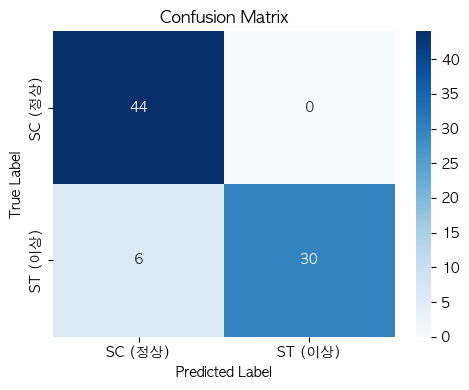

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 혼동행렬 계산
cm = confusion_matrix(y_val, y_pred)

# 라벨 설정
labels = ['SC (정상)', 'ST (이상)']

# 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [94]:
########## threshold value 조정 ##########

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

# 1) Validation set에 대한 예측 확률
proba = model.predict_proba(X_val)[:,1]   # 클래스 1(ST) 확률

# 2) 원하는 threshold 지정 (예: 0.3으로 낮춰서 recall ↑)
threshold = 0.3
y_pred_thresh = (proba >= threshold).astype(int)

# 3) 평가 지표 출력
print(f"Threshold = {threshold}")
print("Precision:", precision_score(y_val, y_pred_thresh))
print("Recall   :", recall_score(y_val, y_pred_thresh))
print("F1       :", f1_score(y_val, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_thresh))

# 4) (선택) Precision-Recall curve로 최적 threshold 찾기
precision, recall, thresholds = precision_recall_curve(y_val, proba)
# 예: recall >= 0.8이 되는 최소 threshold를 찾아보자
idx = (recall >= 0.8).argmax()
print(f"\nRecall>=0.8일 때 threshold ≈ {thresholds[idx]:.3f}, Precision={precision[idx]:.3f}")

Threshold = 0.3
Precision: 0.7804878048780488
Recall   : 0.8888888888888888
F1       : 0.8311688311688312
Confusion Matrix:
 [[35  9]
 [ 4 32]]

Recall>=0.8일 때 threshold ≈ 0.000, Precision=0.450


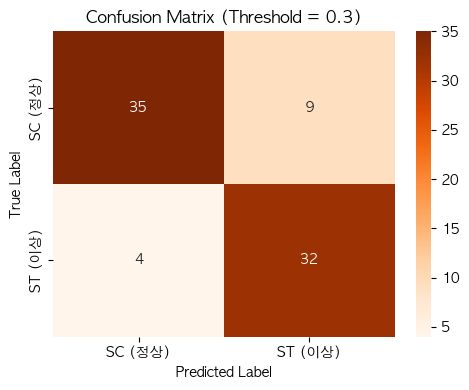

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 혼동행렬 계산
cm_thresh = confusion_matrix(y_val, y_pred_thresh)

# 라벨
labels = ['SC (정상)', 'ST (이상)']

# 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(cm_thresh, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.tight_layout()
plt.show()

In [96]:
# 시각화 1. 상위 20개 feature importance

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature importance 추출
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# 시각화
top_n = 20  # 상위 n개만 보기
plt.figure(figsize=(8, top_n * 0.4))
plt.barh(importance_df['feature'][:top_n], importance_df['importance'][:top_n])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (MDI)")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

# 상위 n개 feature importance 텍스트 출력
top_n = 20
for i, row in importance_df.head(top_n).iterrows():
    print(f"{i+1:2d}. {row['feature']}: {row['importance']:.4f}")

ValueError: All arrays must be of the same length

In [97]:
### 시각화 2. SHAP full feature overview

import shap
import pandas as pd

# ——— 0) Validation set DataFrame 정의 ———
X_val_df = pd.DataFrame(X_val, columns=feature_names)

# ——— 1) Explainer (배경 데이터 포함) ———
X_train_df = pd.DataFrame(X_train, columns=feature_names)
explainer = shap.Explainer(model, X_train_df)

# ——— 2) 검증셋 SHAP 계산 ———
shap_vals = explainer(X_val_df)
# 확인: print(shap_vals.values.shape)  # → (n_samples, n_features, n_classes)

# ——— 3) Class 1 에 대한 Beeswarm (all features) ———
shap.summary_plot(
    shap_vals.values[:, :, 1],   # (samples × features)
    X_val_df,
    feature_names=feature_names,
    title="SHAP Beeswarm for Class 1"
)

# ——— 4) Class 1 에 대한 Bar chart (mean(|SHAP|) 순위) ———
shap.summary_plot(
    shap_vals.values[:, :, 1],
    X_val_df,
    feature_names=feature_names,
    plot_type="bar",
    title="SHAP Feature Importance for Class 1"
)

ValueError: Shape of passed values is (80, 18), indices imply (80, 20)

Best tree index: 78, Validation F1: 0.914


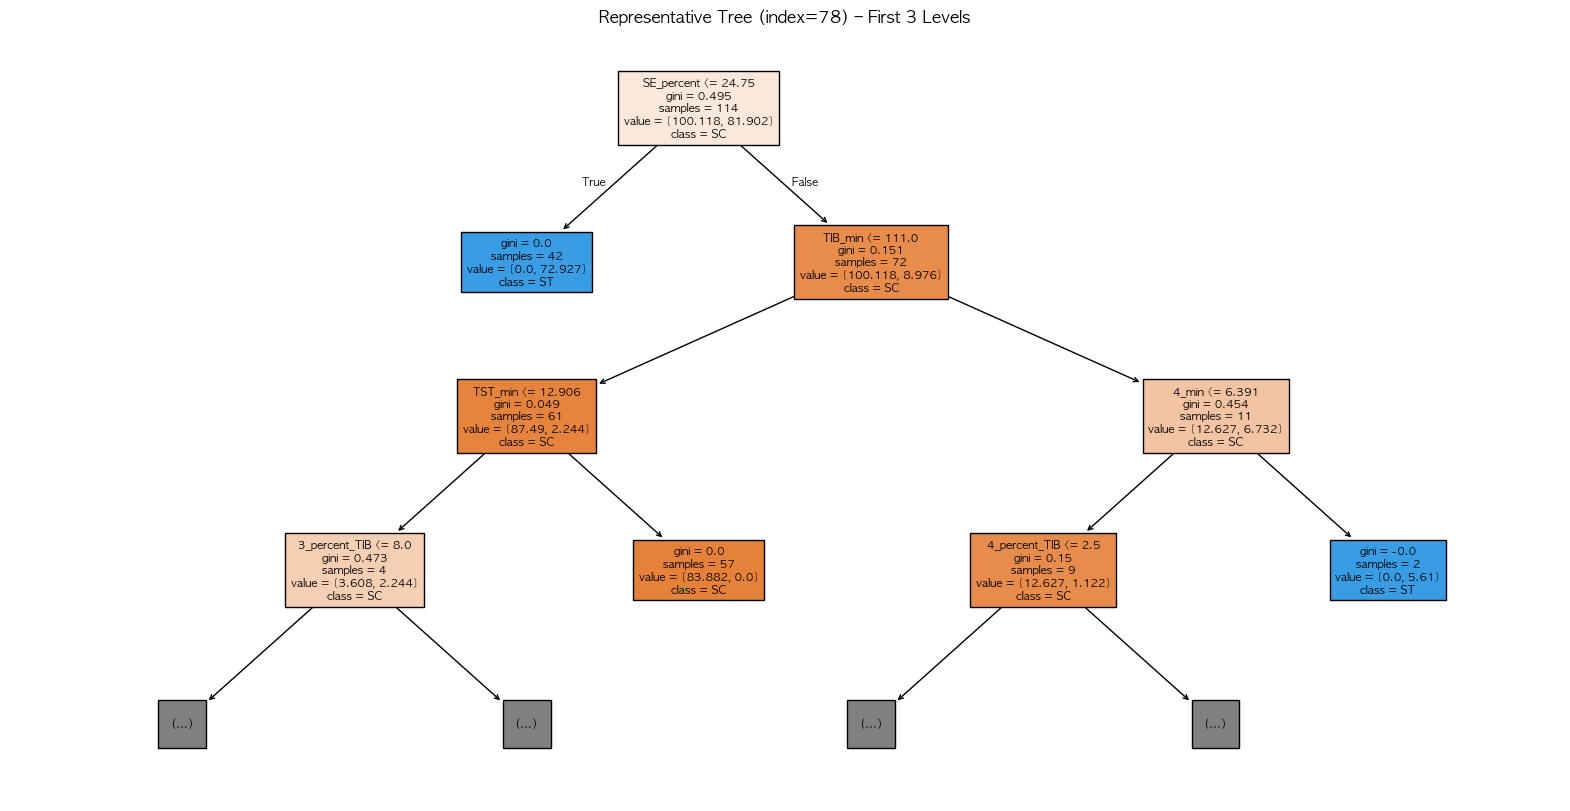

In [98]:
### 시각화 3. 개별 트리 시각화
### 여러 개의 트리 중 가장 F1 score가 좋은 트리를 시각화

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 1) 각 tree의 성능 평가 (Validation F1)
best_idx = None
best_f1  = -1
for i, tree in enumerate(model.estimators_):
    y_pred_tree = tree.predict(X_val)
    f1 = f1_score(y_val, y_pred_tree)
    if f1 > best_f1:
        best_f1  = f1
        best_idx = i

print(f"Best tree index: {best_idx}, Validation F1: {best_f1:.3f}")

# 2) 대표 트리 시각화 (최대 depth=3)
plt.figure(figsize=(20, 10))
plot_tree(
    model.estimators_[best_idx],
    feature_names=feature_names,
    class_names=['SC', 'ST'],
    filled=True,
    max_depth=3,
    fontsize=8
)
plt.title(f"Representative Tree (index={best_idx}) – First 3 Levels")
plt.show()

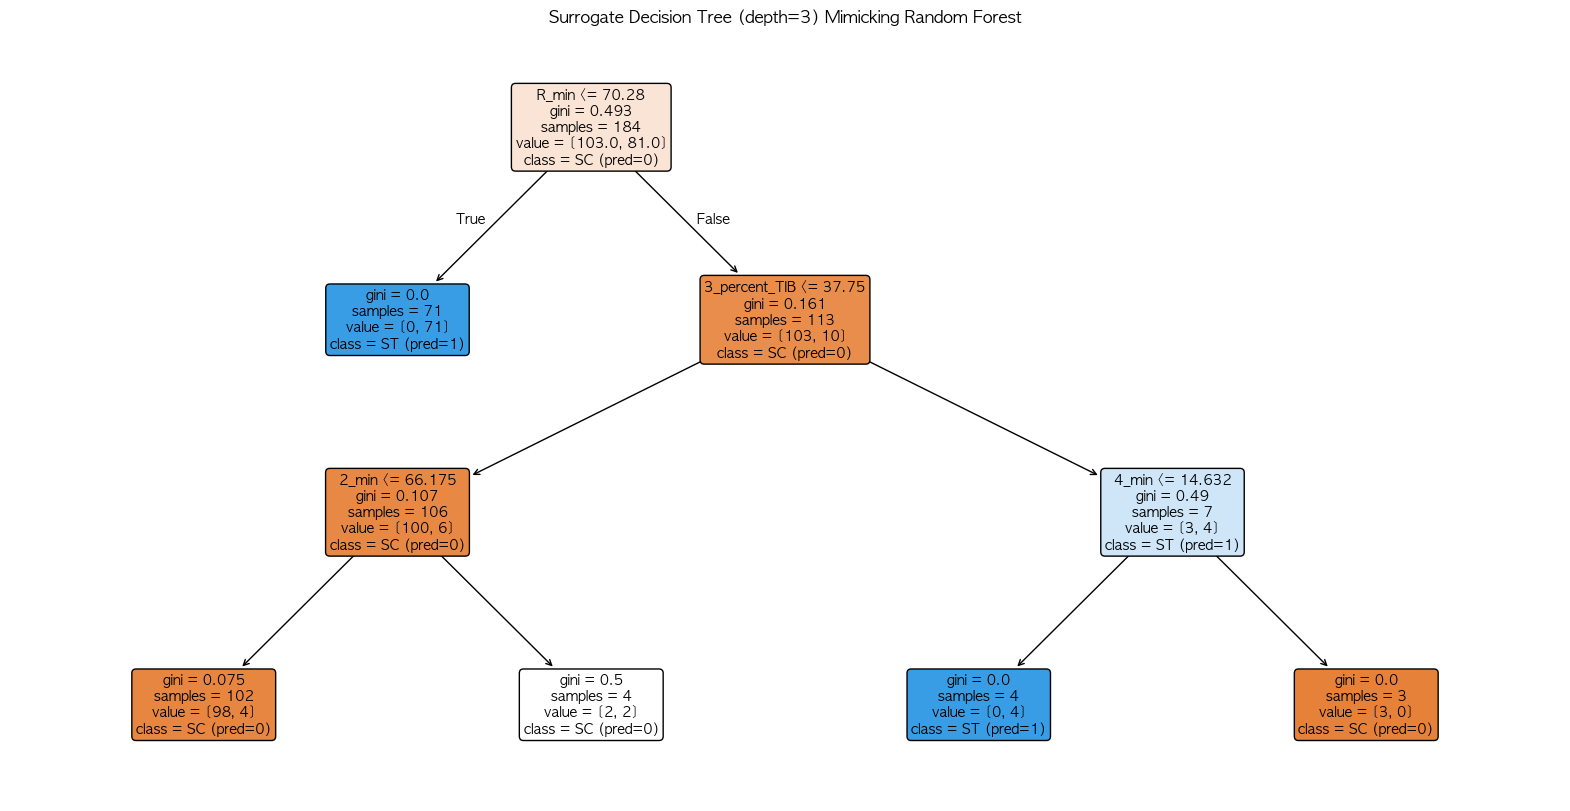

Surrogate Tree Validation F1: 0.879

Classification Report:
              precision    recall  f1-score   support

          SC       0.86      0.98      0.91        44
          ST       0.97      0.81      0.88        36

    accuracy                           0.90        80
   macro avg       0.91      0.89      0.90        80
weighted avg       0.91      0.90      0.90        80

📊 Surrogate Tree Validation Metrics
Precision : 0.967
Recall    : 0.806
F1 Score  : 0.879
Confusion Matrix:
[[43  1]
 [ 7 29]]

Classification Report:
              precision    recall  f1-score   support

          SC       0.86      0.98      0.91        44
          ST       0.97      0.81      0.88        36

    accuracy                           0.90        80
   macro avg       0.91      0.89      0.90        80
weighted avg       0.91      0.90      0.90        80



In [123]:
### 시각화 4. Surrogate Tree. 전체 트리를 근사(approximate)하는 트리

from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# 0) 학습 데이터에 대한 RF 예측(의사 레이블) 생성
rf_labels = model.predict(X_train)

# 1) Surrogate Tree 학습 (깊이 제한)
surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X_train, rf_labels)

# 2) Surrogate Tree 시각화
plt.figure(figsize=(20, 10))
plot_tree(
    surrogate,
    feature_names=feature_names,
    class_names=['SC (pred=0)', 'ST (pred=1)'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Surrogate Decision Tree (depth=3) Mimicking Random Forest")
plt.show()


from sklearn.metrics import f1_score, classification_report

# 1) Surrogate 예측
y_val_pred_sur = surrogate.predict(X_val)

# 2) F1 score 출력
f1 = f1_score(y_val, y_val_pred_sur)
print(f"Surrogate Tree Validation F1: {f1:.3f}")

# 3) 자세한 리포트도 보고 싶다면
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_sur, target_names=['SC', 'ST']))

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 1) Surrogate 예측
y_val_pred_sur = surrogate.predict(X_val)

# 2) 종합 지표 계산
precision = precision_score(y_val, y_val_pred_sur)
recall    = recall_score(y_val, y_val_pred_sur)
f1        = f1_score(y_val, y_val_pred_sur)

# 3) 출력
print("📊 Surrogate Tree Validation Metrics")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_sur))

# 4) (선택) 클래스별 상세 리포트
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_sur, target_names=['SC', 'ST']))

In [100]:
# Permutation feature importance
### 비시각적 해석 1. Permutation. 특성을 각기 무작위로 섞어서 얼마나 성능이 떨어지는지를 보기. 성능이 많이 떨어짐 -> 실제로 중요!
from sklearn.inspection import permutation_importance
import pandas as pd

# compute permutation importance on validation set
result = permutation_importance(
    model,           # 이미 학습된 RandomForestClassifier
    X_val,           # validation feature matrix
    y_val,           # validation labels
    n_repeats=100,    # 반복 횟수 (기본 5 이상 권장
    scoring = 'f1',
    random_state=42,
    n_jobs=-1
)

# 결과를 DataFrame으로 정리하고 importance 순서로 정렬
perm_importance = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False).reset_index(drop=True)

# 출력
print("📌 Permutation Feature Importance (Validation set)")
print(perm_importance)

ValueError: All arrays must be of the same length

In [ ]:
X_df.corr()

In [101]:
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# 모델 재정의 (최신 설정 반영)
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# K-Fold 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
importances_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    model.fit(X_tr, y_tr)
    result = permutation_importance(
        model, X_va, y_va,
        scoring='f1',
        n_repeats=30,
        random_state=42,
        n_jobs=-1
    )
    importances_list.append(result.importances_mean)

# importance 평균 및 표준편차 계산
importances_array = np.array(importances_list)
mean_importance = importances_array.mean(axis=0)
std_importance = importances_array.std(axis=0)

# DataFrame으로 정리
perm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': mean_importance,
    'importance_std': std_importance
}).sort_values(by='importance_mean', ascending=False).reset_index(drop=True)

# 출력
print("📌 K-Fold 기반 Permutation Feature Importance (scoring='f1')")
print(perm_importance_df)

📌 K-Fold 기반 Permutation Feature Importance (scoring='f1')
             feature  importance_mean  importance_std
0              R_min         0.008366        0.016733
1              W_min         0.008125        0.016251
2      W_percent_TIB         0.008044        0.016088
3           WASO_min         0.006230        0.009077
4              2_min         0.005930        0.011859
5     Num_Awakenings         0.005587        0.007877
6            TST_min         0.005060        0.010120
7      2_percent_TIB         0.003350        0.006699
8           REML_min         0.003337        0.009832
9      1_percent_TIB         0.002559        0.005117
10  Num_Stage_Shifts         0.002448        0.004664
11           TIB_min         0.002208        0.007283
12     R_percent_TST         0.001170        0.006418
13     4_percent_TIB         0.001091        0.012394
14             4_min         0.000562        0.013388
15             1_min         0.000448        0.008855
16        SE_percent    

In [102]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# PCA
n_components = 5  # 주성분 5개로 압축
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# K-Fold 기반 permutation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
importances_list = []

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

for train_idx, val_idx in kf.split(X_pca, y):
    X_tr, X_va = X_pca[train_idx], X_pca[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    model.fit(X_tr, y_tr)
    result = permutation_importance(
        model, X_va, y_va,
        scoring='f1', n_repeats=30,
        random_state=42, n_jobs=-1
    )
    importances_list.append(result.importances_mean)

# 평균 및 표준편차 정리
importances_array = np.array(importances_list)
mean_importance = importances_array.mean(axis=0)
std_importance = importances_array.std(axis=0)

pca_importance_df = pd.DataFrame({
    'PC': [f"PC{i+1}" for i in range(n_components)],
    'importance_mean': mean_importance,
    'importance_std': std_importance
}).sort_values(by='importance_mean', ascending=False).reset_index(drop=True)

# 출력
print("📌 PCA 기반 Permutation Feature Importance")
print(pca_importance_df)

📌 PCA 기반 Permutation Feature Importance
    PC  importance_mean  importance_std
0  PC1         0.452052        0.035784
1  PC2         0.017939        0.017549
2  PC3         0.013780        0.007636
3  PC4         0.000724        0.013282
4  PC5        -0.001672        0.012168


In [111]:
# 각 주성분이 설명하는 분산 비율 출력
explained_ratio = pca.explained_variance_ratio_
for i, ratio in enumerate(explained_ratio, 1):
    print(f"PC{i}: {ratio:.4f}")

PC1: 0.6414
PC2: 0.1901
PC3: 0.0744
PC4: 0.0331
PC5: 0.0282


In [112]:
# PC1의 구성 feature 가중치 (loading vector)
pc1_weights = pd.Series(pca.components_[0], index=X_df.columns).sort_values(key=abs, ascending=False)

print("🔍 PC1을 가장 많이 구성하는 feature TOP 10:")
print(pc1_weights.head(10))

🔍 PC1을 가장 많이 구성하는 feature TOP 10:
TST_min             0.709546
2_min              -0.391141
REML_min            0.337922
TIB_min             0.281907
R_percent_TST      -0.207614
Num_Stage_Shifts    0.205359
SE_percent          0.145744
2_percent_TIB      -0.120408
W_min               0.109371
1_min              -0.087281
dtype: float64


In [105]:
def smart_remove_correlated_features(df, target, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = set()

    for col in upper.columns:
        for row in upper.index:
            if upper.loc[row, col] > threshold:
                # 둘 중 target과 상관이 작은 것 제거
                corr_row = abs(np.corrcoef(df[row], target)[0, 1])
                corr_col = abs(np.corrcoef(df[col], target)[0, 1])

                if corr_row < corr_col:
                    to_drop.add(row)
                else:
                    to_drop.add(col)

    return df.drop(columns=list(to_drop)), list(to_drop)

X_df_smart_reduced, dropped_smart = smart_remove_correlated_features(X_df, y, threshold=0.9)

print("🧠 정보 기반으로 제거한 feature들:")
print(dropped_smart)

🧠 정보 기반으로 제거한 feature들:
['SE_percent', '3_min', '2_percent_TIB', '4_min', '2_min', '1_min', 'Num_Awakenings', 'TST_min']


In [106]:
# 중복 feature 제거 후의 데이터 기준
X_reduced = X_df_reduced.values
feature_names_reduced = X_df_reduced.columns.tolist()

# 모델 학습 (한 번만)
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_reduced, y)

# Gini importance 추출
gini_importance = model.feature_importances_

# 정리
gini_df = pd.DataFrame({
    'feature': feature_names_reduced,
    'gini_importance': gini_importance
}).sort_values(by='gini_importance', ascending=False).reset_index(drop=True)

# 출력
print("📌 Gini Feature Importance (RF Internal)")
print(gini_df.head(10))

📌 Gini Feature Importance (RF Internal)
         feature  gini_importance
0  R_percent_TST         0.173579
1          2_min         0.142879
2       REML_min         0.106472
3  2_percent_TIB         0.104524
4        TST_min         0.080316
5  1_percent_TIB         0.071456
6     SE_percent         0.065518
7          1_min         0.064384
8  3_percent_TIB         0.028930
9  4_percent_TIB         0.024199


In [107]:
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

X_reduced = X_df_reduced.values
feature_names_reduced = X_df_reduced.columns.tolist()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
importances_list = []

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

for train_idx, val_idx in kf.split(X_reduced, y):
    X_tr, X_va = X_reduced[train_idx], X_reduced[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    model.fit(X_tr, y_tr)
    result = permutation_importance(
        model, X_va, y_va,
        scoring='f1',
        n_repeats=30,
        random_state=42,
        n_jobs=-1
    )
    importances_list.append(result.importances_mean)

# 평균 및 표준편차 정리
importances_array = np.array(importances_list)
mean_importance = importances_array.mean(axis=0)
std_importance = importances_array.std(axis=0)

perm_importance_df = pd.DataFrame({
    'feature': feature_names_reduced,
    'importance_mean': mean_importance,
    'importance_std': std_importance
}).sort_values(by='importance_mean', ascending=False).reset_index(drop=True)

# 출력
print("📌 중복 feature 제거 후 Permutation Feature Importance (scoring='f1')")
print(perm_importance_df)

📌 중복 feature 제거 후 Permutation Feature Importance (scoring='f1')
             feature  importance_mean  importance_std
0           REML_min         0.007293        0.008628
1      2_percent_TIB         0.005126        0.007668
2      R_percent_TST         0.004970        0.011028
3              W_min         0.004714        0.009428
4      W_percent_TIB         0.004139        0.007645
5            TST_min         0.004050        0.010503
6              R_min         0.003872        0.007744
7              2_min         0.003865        0.010064
8   Num_Stage_Shifts         0.003292        0.004464
9           WASO_min         0.002185        0.007438
10             3_min         0.001537        0.003074
11     3_percent_TIB         0.000330        0.004312
12    Num_Awakenings        -0.000193        0.002353
13     1_percent_TIB        -0.001271        0.002597
14             4_min        -0.002031        0.008480
15        SE_percent        -0.002436        0.006825
16     4_percent_T

In [114]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf_importance_list = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(X_reduced, y):
    X_tr, y_tr = X_reduced[train_idx], y[train_idx]

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr, y_tr)
    rf_importance_list.append(model.feature_importances_)

# 평균화
rf_importance_array = np.array(rf_importance_list)
rf_importance_mean = rf_importance_array.mean(axis=0)

rf_importance = rf_importance_mean  # 여기만 바꾸면 돼



# 이미 존재한다고 가정: perm_importance_df (K-Fold 기반 permutation 결과)

# Step 1: index로 변환
perm_df = perm_importance_df.set_index('feature')

# Step 2: 교집합 정렬
common_features = [f for f in feature_names_reduced if f in perm_df.index]

# Step 3: align된 중요도 추출
rf_importance_common = [rf_importance_mean[feature_names_reduced.index(f)] for f in common_features]
perm_mean_common     = perm_df.loc[common_features, 'importance_mean'].values

# Step 4: hybrid 계산
hybrid_importance = np.array(rf_importance_common) * perm_mean_common

# Step 5: 정리
hybrid_df = pd.DataFrame({
    'feature': common_features,
    'permutation_importance': perm_mean_common,
    'rf_importance': rf_importance_common,
    'hybrid_importance': hybrid_importance
}).sort_values(by='hybrid_importance', ascending=False).reset_index(drop=True)

print("📌 Hybrid Feature Importance (K-Fold RF × Permutation)")
print(hybrid_df.head(20))

📌 Hybrid Feature Importance (K-Fold RF × Permutation)
             feature  permutation_importance  rf_importance  hybrid_importance
0      R_percent_TST                0.004970       0.169744           0.000844
1           REML_min                0.007293       0.102742           0.000749
2      2_percent_TIB                0.005126       0.104662           0.000536
3              2_min                0.003865       0.133681           0.000517
4            TST_min                0.004050       0.100597           0.000407
5              W_min                0.004714       0.018906           0.000089
6      W_percent_TIB                0.004139       0.020934           0.000087
7              R_min                0.003872       0.020568           0.000080
8   Num_Stage_Shifts                0.003292       0.016661           0.000055
9              3_min                0.001537       0.021491           0.000033
10          WASO_min                0.002185       0.012448           0.00002

In [118]:
top_features = ['R_percent_TST', 'REML_min', '2_percent_TIB', '2_min', 'TST_min', 'W_min']

# X: 최종 정제된 데이터셋 (외생 요인 제거 후)
# feature_names_reduced: X의 컬럼 이름 리스트

import pandas as pd

# ← 바로 이 줄에서 X → X_reduced 로 수정
X_df_reduced = pd.DataFrame(X_reduced, columns=feature_names_reduced)

# 이제 top feature만 선택
# top_features = ['REML_min', '1_min', '2_min', 'R_min', '3_min']
X_sub = X_df_reduced[top_features].values



from sklearn.model_selection import train_test_split

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_sub, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# 모델 정의
model_reduced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 학습
model_reduced.fit(X_train_sub, y_train_sub)

# 예측
y_pred_sub = model_reduced.predict(X_val_sub)

# 평가 출력
print("📊 Reduced Model (Top 5 Hybrid Features) Evaluation")
print("F1 Score   :", f1_score(y_val_sub, y_pred_sub))
print("Precision  :", precision_score(y_val_sub, y_pred_sub))
print("Recall     :", recall_score(y_val_sub, y_pred_sub))
print("Confusion Matrix:\n", confusion_matrix(y_val_sub, y_pred_sub))

📊 Reduced Model (Top 5 Hybrid Features) Evaluation
F1 Score   : 0.9130434782608695
Precision  : 0.9545454545454546
Recall     : 0.875
Confusion Matrix:
 [[28  1]
 [ 3 21]]


In [119]:
# ─ 모델 학습까지는 그대로 ─
model_reduced.fit(X_train_sub, y_train_sub)

# ─ threshold 조절을 위한 예측 확률 계산 ─
proba_sub = model_reduced.predict_proba(X_val_sub)[:, 1]  # 클래스 1 확률

# 원하는 threshold 지정 (예: 0.25)
threshold = 0.25
y_pred_thresh = (proba_sub >= threshold).astype(int)

# 평가 출력
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print(f"Threshold = {threshold}")
print("📊 Reduced Model (Top 5 Hybrid Features) Evaluation with Threshold")
print("F1 Score   :", f1_score(y_val_sub, y_pred_thresh))
print("Precision  :", precision_score(y_val_sub, y_pred_thresh))
print("Recall     :", recall_score(y_val_sub, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_val_sub, y_pred_thresh))

Threshold = 0.25
📊 Reduced Model (Top 5 Hybrid Features) Evaluation with Threshold
F1 Score   : 0.9166666666666666
Precision  : 0.9166666666666666
Recall     : 0.9166666666666666
Confusion Matrix:
 [[27  2]
 [ 2 22]]


AUC : 0.9626436781609194


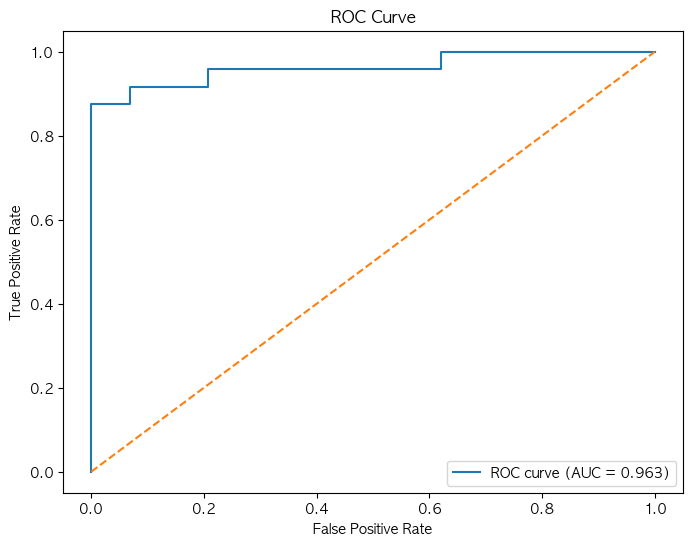

In [124]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1) AUC 계산
auc = roc_auc_score(y_val_sub, proba_sub)
print("AUC :", auc)

# 2) ROC curve를 그리고 싶다면
fpr, tpr, thresholds = roc_curve(y_val_sub, proba_sub)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # 랜덤 예측 기준선
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()